In [15]:
import os
import cv2
import numpy as np
import fnmatch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dense, Flatten
from tensorflow.keras.layers import Conv2DTranspose, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [16]:
def load_data(normal_data, malignant_data, benign_data):
    categories = [('normal', normal_data), ('malignant', malignant_data), ('benign', benign_data)]
    images = []
    labels = []
    masks = []

    for label, folder in categories:
        for filename in os.listdir(folder):
            if filename.endswith('.png') and not filename.endswith('_mask.png'):
                img_path = os.path.join(folder, filename)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (128, 128))

                mask_pattern = filename.split('.png')[0] + '_mask*.png'
                mask_paths = [os.path.join(folder, f) for f in os.listdir(folder) if fnmatch.fnmatch(f, mask_pattern)]

                if not mask_paths:  # If no masks are found for the image
                    mask_combined = np.zeros((128, 128))  # Create an empty mask
                else:
                    mask_combined = None

                    for mask_path in mask_paths:
                        mask = cv2.imread(mask_path, 0)
                        mask = cv2.resize(mask, (128, 128))
                        if mask_combined is None:
                            mask_combined = mask
                        else:
                            mask_combined = np.maximum(mask_combined, mask)

                images.append(img)
                labels.append(label)
                masks.append(mask_combined)

    images = np.array(images) / 255.0
    masks = np.array(masks, dtype=np.float32) / 255.0  # Ensure correct data type
    masks = masks.reshape((-1, 128, 128, 1))  # Reshape masks for model input

    return images, labels, masks



In [17]:
# Paths to the data folders
normal_data = r"C:\Users\7J6594897\Desktop\Github Projects\CNN-ImageAnomalyDetection\Dataset_BUSI_with_GT\normal"
malignant_data = r"C:\Users\7J6594897\Desktop\Github Projects\CNN-ImageAnomalyDetection\Dataset_BUSI_with_GT\malignant"
benign_data = r"C:\Users\7J6594897\Desktop\Github Projects\CNN-ImageAnomalyDetection\Dataset_BUSI_with_GT\benign"

# Load the dataset
images, labels, masks = load_data(normal_data, malignant_data, benign_data)

In [18]:
# Encode label
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoded = to_categorical(integer_encoded)
# Split the dataset
train_images, test_images, train_masks, test_masks, train_labels, test_labels = train_test_split(images, masks, onehot_encoded, test_size=0.15)

In [19]:
#from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout

def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the U-Net model
unet = unet_model()

In [20]:
model = unet_model()
history = model.fit(train_images, train_masks, batch_size=32, epochs=20, validation_split=0.15)


Epoch 1/20
18/18 [==============================] - 60s 3s/step - loss: 0.4295 - accuracy: 0.8676 - val_loss: 0.3230 - val_accuracy: 0.9109
Epoch 2/20
18/18 [==============================] - 42s 2s/step - loss: 0.2645 - accuracy: 0.9238 - val_loss: 0.2529 - val_accuracy: 0.9109
Epoch 3/20
18/18 [==============================] - 39s 2s/step - loss: 0.2253 - accuracy: 0.9239 - val_loss: 0.2541 - val_accuracy: 0.9109
Epoch 4/20
18/18 [==============================] - 38s 2s/step - loss: 0.2071 - accuracy: 0.9239 - val_loss: 0.2351 - val_accuracy: 0.9109
Epoch 5/20
18/18 [==============================] - 38s 2s/step - loss: 0.1999 - accuracy: 0.9239 - val_loss: 0.2214 - val_accuracy: 0.9109
Epoch 6/20
18/18 [==============================] - 38s 2s/step - loss: 0.1973 - accuracy: 0.9239 - val_loss: 0.2183 - val_accuracy: 0.9109
Epoch 7/20
18/18 [==============================] - 39s 2s/step - loss: 0.1911 - accuracy: 0.9239 - val_loss: 0.2424 - val_accuracy: 0.9109
Epoch 8/20
18/18 [==

In [21]:
test_loss, test_accuracy = model.evaluate(test_images, test_masks)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


4/4 [==============================] - 1s 247ms/step - loss: 0.1359 - accuracy: 0.9487
Test Loss: 0.1358841508626938, Test Accuracy: 0.948718249797821


1/1 [==============================] - 0s 213ms/step


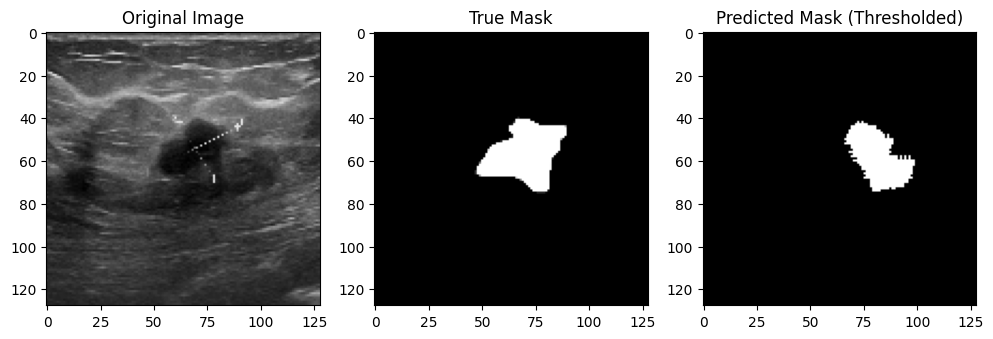

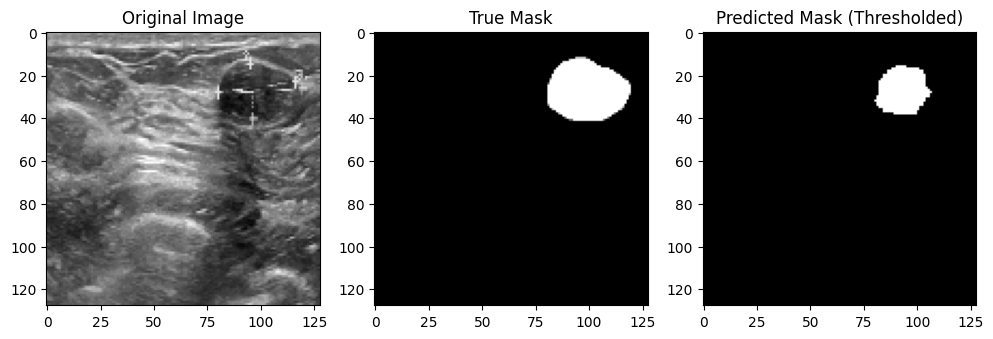

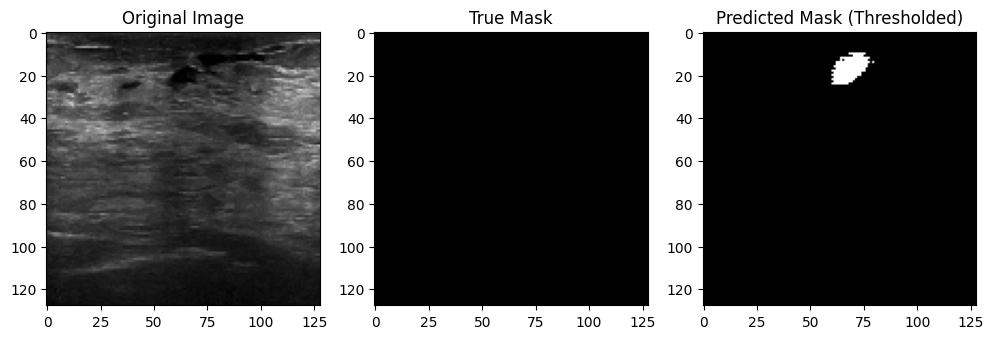

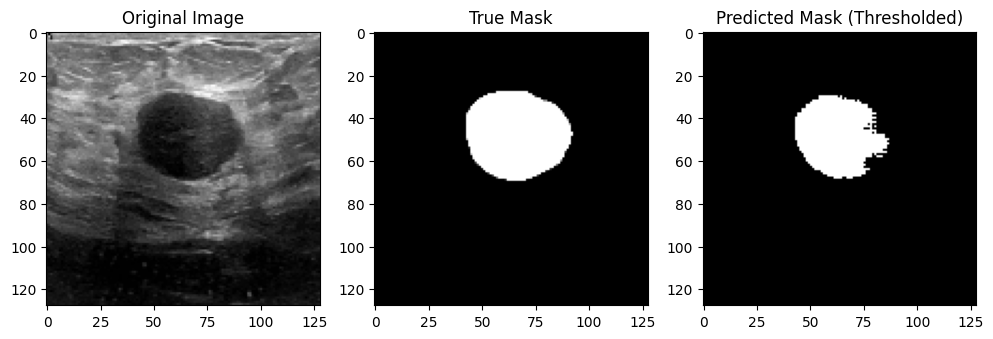

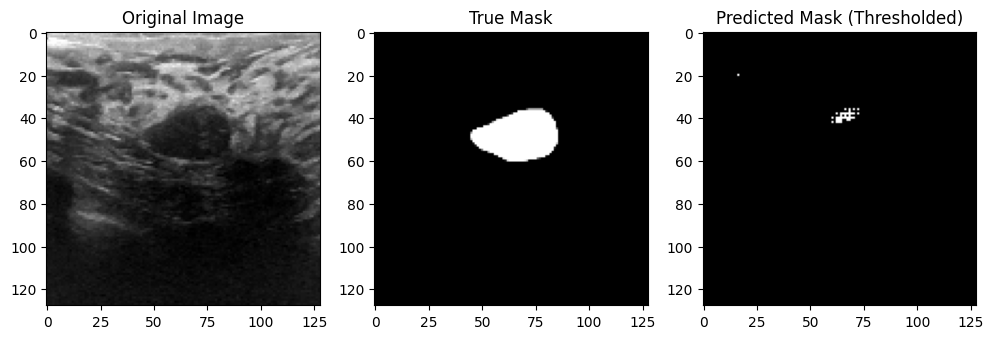

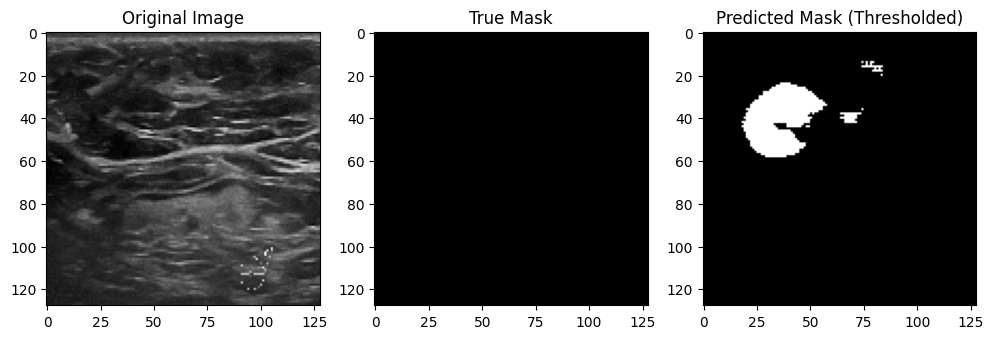

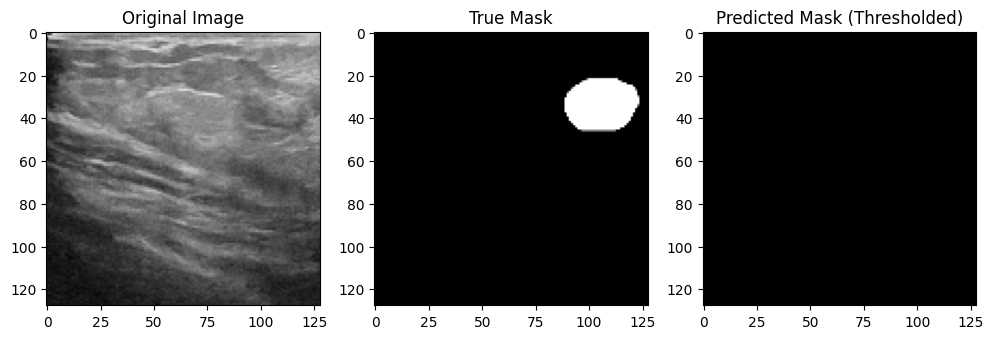

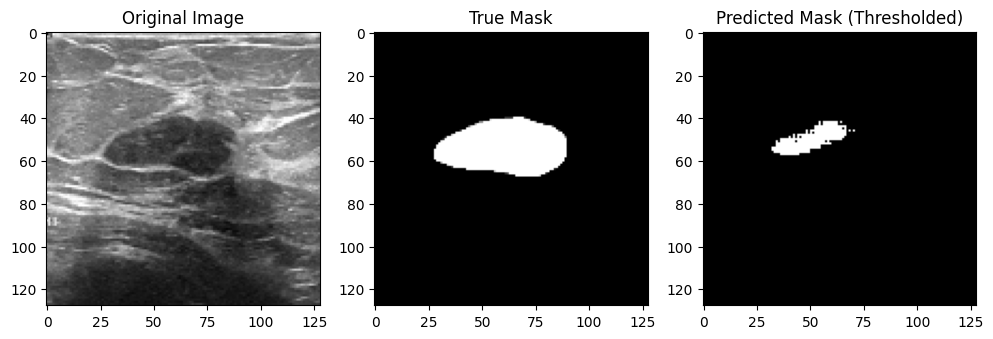

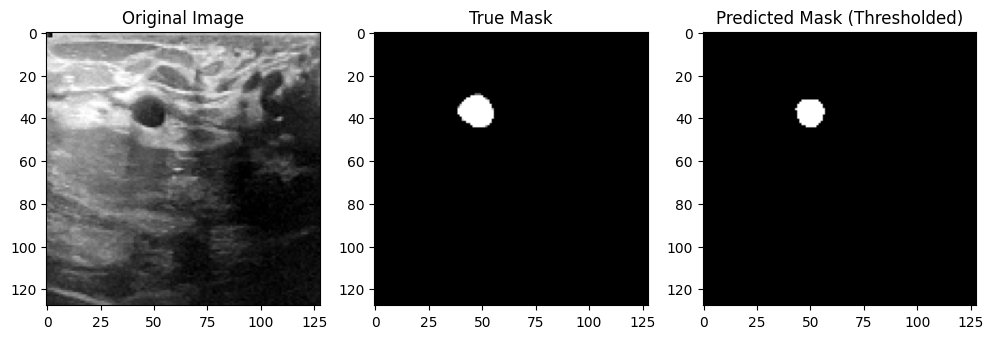

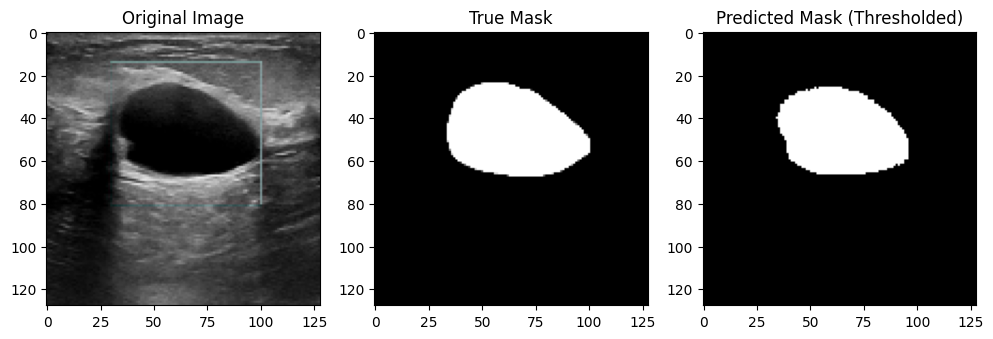

In [24]:
# Predict masks for some test images
n_samples = 10
sample_images = test_images[:n_samples]
predicted_masks = model.predict(sample_images)

# Apply threshold
threshold = 0.7  # 65%
predicted_masks_thresholded = (predicted_masks > threshold).astype(int)

# Plot the results with thresholding
for i in range(n_samples):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i])
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(test_masks[i].squeeze(), cmap='gray')
    plt.title('True Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks_thresholded[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask (Thresholded)')

    plt.show()
